# Analyzing Reddit's Sentimental Shifts during COVID-19

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Distilbert for sentiment analysis
# https://huggingface.co/bhadresh-savani/distilbert-base-uncased-emotion?text=I+feel+a+bit+let+down
from transformers import pipeline

from tqdm import tqdm # for prgress bar

c:\Users\farih\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
text_submissions_df = pd.read_csv("text_submissions.csv")

C:\Users\farih\AppData\Local\Temp\ipykernel_33276\2287351077.py:1: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  text_submissions_df = pd.read_csv("data/text_submissions.csv")


## Data Clearning & Pre-processing
Our pre-processing for the text submissions dataset includes the following:
- Bot Detection: We have removed rows with `bot` or `mod` in the author names. Note that we also drop the author column after removing these.
- Removed Posts: If a submission has `selftext` as empty, [deleted], or [removed] then, we remove those as well.
- `created_utc` is a UNIX timestamp, so we convert it to an integer.
- We drop rows with na `title`, `selftext`, or `created_utc`
- Finally we drop columns `author`, `domain`, `is_self`, `score`, `subreddit` as they aren't necessary for our analysis.

In [8]:
# remove rows with mod or bot as the author
text_submissions_df = text_submissions_df[~text_submissions_df['author'].str.lower().str.contains('bot|mod')]

# remove rows where selftext is 'deleted' or 'removed'
text_submissions_df = text_submissions_df[(text_submissions_df['selftext'] != '[deleted]') & (text_submissions_df['selftext'] != '[removed]')]

# convert created_utc to an int and drop rows with invalid dates
text_submissions_df=text_submissions_df[~(text_submissions_df['created_utc'] == "CPTSD")]
text_submissions_df['created_utc'] = text_submissions_df['created_utc'].astype(int)

# drop rows where created_utc, selftext, or title are na
text_submissions_df.dropna(subset=['created_utc', 'selftext', 'title'], inplace=True) 

# drop submissions with title or text that is empty
text_submissions_df.drop(text_submissions_df[text_submissions_df['title'] == ''].index, inplace=True)
text_submissions_df.drop(text_submissions_df[text_submissions_df['selftext'] == ''].index, inplace=True)

# dropping unnecessary columns
text_submissions_df.drop(columns=['author', 'domain', 'is_self', 'score', 'subreddit'], inplace=True)

In [9]:
# cleaned and pre-processed dataframe
text_submissions_df.head()

,id,created_utc,selftext,title
12,t3_o5e7es,1624335746,This is probably a long shot. I’m trans masc n...,Trans masc beauty yters?
26,t3_kw0d6q,1610484530,[Link to first post](https://www.reddit.com/r/...,We are extending the poll!
32,t3_l0vikr,1611096862,Can anyone share there are favorite under the ...,Under the Radar Beauty
35,t3_l2hubw,1611296858,Disclaimer: This is extremely personal to me a...,Conflicted Feelings about Sarah Cheung
39,t3_l92pdu,1612061469,[ Removed by reddit in response to a copyright...,L*llee Jean is bullying yet another creator


### Splitting submissions pre-pandemic and pandemic times
We will split `text_submissions` to two time-based dataframes: before and after Feb 1, 2020, similar to the date chosen for the start of the pandemic in the paper. 

In [ ]:
start_of_covid = 1580515200 # UNIX timestamp for Feb 1, 2020 00:00:00 UTC = 1580515200

submissions_pre_df = text_submissions_df[text_submissions_df['created_utc'] < start_of_covid]
submissions_post_df = text_submissions_df[text_submissions_df['created_utc'] >= start_of_covid]

In [ ]:
# storing pre and post pandemic cleaned dataframes
submissions_pre_df.to_csv('text_submissions_pre.csv')
submissions_post_df.to_csv("text_submissions_post.csv")

### Detecting COVID related posts
We detect submissions related to covid by searching in the their `title` or `selftext` for covid related words (with no case sensitivity).

In [ ]:
covid_related_words = ['pandemic', 'covid', 'coronavirus', 'covid-19', 'quarantine', 
                       'lockdown', 'vaccination', 'delta variant', 'mask', 'social distancing', 
                       'vaccinate', 'isolation', 'booster dose', 'booster shot', 'contact tracing'] 
search_pattern = '|'.join(covid_related_words)
covid_submissions = text_submissions_df[text_submissions_df['title'].str.contains(search_pattern, case=False) | 
                                        text_submissions_df['selftext'].str.contains(search_pattern, case=False)]

covid_submissions.head(5)

In [8]:
print(f'total covid submission posts: {len(covid_submissions)}, total posts: {len(text_submissions_df)}')

total covid submission posts: 22513, total posts: 746250


## Exploratory Analysis
We note that the following exploratory analysis is only done on a subset of the actual data. This is because
we've yet to find an efficient way to load and process large datasets like these. We've listed out our attempted ways in README.md but still looking for more efficient ways.
Doing any operations with this large data still takes hours, but we shall find a way of processing the full data soon.

### Example of using distilbert
DistilBERT is the library that we will be using to give textual data sentiment scores. The model is a smaller, cheaper, and lighter version of BERT and can provide probabilities (between 0-1) or scores indicating the likelihood of certain emotions being present in the analyzed text. The model provides scores for the following emotions based on the text given: sadness, joy, love, anger, fear, surprise.

Read more here: https://huggingface.co/docs/transformers/model_doc/distilbert

In [5]:
# sample usage
classifier = pipeline("text-classification",model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=True)
prediction = classifier(["I love using transformers.", "I hate you so much"],)
prediction

c:\Users\farih\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\pipelines\text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'sadness', 'score': 0.007511443924158812},
  {'label': 'joy', 'score': 0.8325576186180115},
  {'label': 'love', 'score': 0.014407174661755562},
  {'label': 'anger', 'score': 0.13556718826293945},
  {'label': 'fear', 'score': 0.008320356719195843},
  {'label': 'surprise', 'score': 0.001636205823160708}],
 [{'label': 'sadness', 'score': 0.0486312210559845},
  {'label': 'joy', 'score': 0.007470841519534588},
  {'label': 'love', 'score': 0.03859546408057213},
  {'label': 'anger', 'score': 0.9020034074783325},
  {'label': 'fear', 'score': 0.0024381058756262064},
  {'label': 'surprise', 'score': 0.0008610452059656382}]]

### Finding sentiment scores 
Using DistilBERT we want to find sentiment scores for each sentiment for 2 of our datasets:
1. Pre-pandemic submissions (called `submissions_pre_df`)
2. Post pandemic submissions related to COVID (called `covid_submissions`)

In [ ]:
# add new columns in submissions dataframe for each emotion and set all to NaN
emotions = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
for emotion in emotions:
    submissions_pre_df[emotion] = float('NaN')
    covid_submissions[emotion] = float('NaN')
    submissions_post_df[emotion] = float('NaN')

We now find the sentiment scores for the `title` of each of the submissions. We store these scores in the corresponding columns of our pre-covid and post-covid datasets. 

Ideally, we wanted to do this for the `selftext` column which contains the body of the submissions, but the trasnformer model had a limit to the number of characters
it could process and a lot of the submissions had bodies of text that went over this limit. We know there is a solution to this problem, but we were limited in time and didn't process the bodies.

In [134]:
# extract sentiment scores for each sentiment for the submissions_pre_df titles
total_rows = len(submissions_pre_df)
with tqdm(total=total_rows) as pbar:
  for index, row in submissions_pre_df.iterrows():
      scores = classifier(row['title'])[0]
      for score in scores:
          emotion = score['label']
          submissions_pre_df.at[index, emotion] = score['score']
      
      pbar.update(1)
      pbar.set_description(f'processing: {((index + 1) / total_rows) * 100:.2f}%')  # display progress percentage

  0%|          | 0/276587 [00:00<?, ?it/s]

processing: 118.08%:   1%|          | 1970/276587 [02:06<4:52:36, 15.64it/s]

In [19]:
# extract sentiment scores for each sentiment for the covid_submissions titles
total_rows = len(covid_submissions)
with tqdm(total=total_rows) as pbar:
  for index, row in covid_submissions.iterrows():
      scores = classifier(row['title'])[0]
      for score in scores:
          emotion = score['label']
          covid_submissions.at[index, emotion] = score['score']
      
      pbar.update(1)
      pbar.set_description(f'processing: {((index + 1) / total_rows) * 100:.2f}%')  # display progress percentage

  0%|          | 0/22513 [00:00<?, ?it/s]/home/ava/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/home/ava/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
processing: 15528.75%: 100%|██████████| 22513/22513 [22:37<00:00, 16.58it/s]


In [ ]:
# extract score for each emotion and set the score to the particular column - submissions_post_df
total_rows = len(submissions_post_df)
with tqdm(total=total_rows) as pbar:
  for index, row in submissions_post_df.iterrows():
      scores = classifier(row['title'])[0]
      for score in scores:
          emotion = score['label']
          submissions_post_df.at[index, emotion] = score['score']
      
      pbar.update(1)
      pbar.set_description(f'processing: {((index + 1) / total_rows) * 100:.2f}%')  # display progress percentage

In [ ]:
# Above, we ran the for loop for 37% of the total submissions_post_df length, so a subset (175k) of the rows had their sentiment scores calculated. The rows that didn't have the scores calculated have NaN values, so dropping those rows. 
submissions_post_df_subset = submissions_post_df[~submissions_post_df["sadness"].isna()]

In [139]:
submissions_pre_df.head()

,id,created_utc,selftext,title,sadness,joy,love,anger,fear,surprise
212,t3_em1w6v,1578530685,"So I have been rereading mistborn era 2, and i...",Lerasium,0.067617,0.034112,0.004852,0.415060,0.470635,0.007724
214,t3_eqzjta,1579456312,Given the fact that Returned are able to shape...,Questions about Susebron,0.010532,0.034193,0.002479,0.629985,0.319326,0.003486
217,t3_euv8g2,1580162352,"Hey everyone, I was reading the way of kings ...",Horses in Roshar¿?,0.016293,0.056722,0.003681,0.539356,0.377168,0.006781
1288,t3_ejssrp,1578118184,Just came to the realization that chipper and ...,Chipper vs Marte (click before you judge),0.003510,0.012096,0.000669,0.974805,0.008069,0.000850
1292,t3_elgw7a,1578427673,Ty,Can someone post the new cards stats,0.036035,0.834501,0.002555,0.091958,0.032056,0.002895


In [12]:
covid_submissions.head()

,id,created_utc,selftext,title,sadness,joy,love,anger,fear,surprise
183,t3_l6alkg,1611770706,"Hi All,\n\nUsual story, started reading Storml...",Where to buy good cosmere related Art?,NaN,NaN,NaN,NaN,NaN,NaN
253,t3_i6adqf,1596934184,A spooky spren? Ominous mist? Lapses in the re...,What would Covid look like in the cognitive re...,NaN,NaN,NaN,NaN,NaN,NaN
467,t3_fzci8u,1586628822,Is it just broken this year I only get too lat...,Online Hitting Timing with Fastballs,NaN,NaN,NaN,NaN,NaN,NaN
615,t3_g7f93g,1587757812,shout out to SDS for giving us an incredible a...,Who are you grinding for first?,NaN,NaN,NaN,NaN,NaN,NaN
646,t3_i10gny,1596166618,this is what quarantine does to me\n\n20\n\nBi...,"drop your lineup right now, and if you can rem...",NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
submissions_post_df_subset.head()

,id,created_utc,selftext,title,sadness,joy,love,anger,fear,surprise
12,t3_o5e7es,1624335746,This is probably a long shot. I’m trans masc n...,Trans masc beauty yters?,0.025052,0.483623,0.008406,0.412990,0.064009,0.005920
26,t3_kw0d6q,1610484530,[Link to first post](https://www.reddit.com/r/...,We are extending the poll!,0.007378,0.172137,0.004655,0.803168,0.010309,0.002353
32,t3_l0vikr,1611096862,Can anyone share there are favorite under the ...,Under the Radar Beauty,0.020358,0.897732,0.017415,0.039150,0.019249,0.006097
35,t3_l2hubw,1611296858,Disclaimer: This is extremely personal to me a...,Conflicted Feelings about Sarah Cheung,0.024518,0.001687,0.000956,0.946456,0.026021,0.000362
39,t3_l92pdu,1612061469,[ Removed by reddit in response to a copyright...,L*llee Jean is bullying yet another creator,0.005010,0.000537,0.000460,0.981904,0.011787,0.000302


In [ ]:
# save modified datasets
submissions_pre_df.to_csv('submissions_pre_with_sentiments.csv')
covid_submissions.to_csv('covid_submissions_post_with_sentiments.csv')
submissions_post_df_subset.to_csv("subset_submissions_with_sentiments_nanremoved.csv")

### Average pre-pandemic submission sentiment score
We want to find the average score (0-1) for each sentiment for pre-pandemic submissions.

In [11]:
submissions_sentiments_pre = pd.read_csv("submissions_pre_with_sentiments.csv")
submissions_covid_sentiments = pd.read_csv("covid_submissions_post_with_sentiments.csv")
submissions_post_df_subset = pd.read_csv("subset_submissions_with_sentiments_nanremoved.csv")

In [12]:
emotion_to_avg_score = {}
for e in emotions:
  emotion_to_avg_score[e] = submissions_sentiments_pre[e].mean()
  print(f"average {e} score: {emotion_to_avg_score[e]}")

average sadness score: 0.0840655441961972
average joy score: 0.3918919424934133
average love score: 0.011895255271032662
average anger score: 0.3456912151362991
average fear score: 0.15761704135428448
average surprise score: 0.00883900153912895


### Frequency distribution of Submissions with Sentiment Scores Above Average
Now that we've calculated the average sentiment score for a pre-pandemic post for every sentiment, 
we want to visualize how many submissions have sentiment score above and below the average
sentiment scores.

In [12]:
# store counts of submissions that have below and above the average sentiment scores
above_avg, below_avg = {}, {}

for e in emotions:
    avg_emotion_score = emotion_to_avg_score[e]
    
    above_count = submissions_covid_sentiments[e][submissions_covid_sentiments[e] > avg_emotion_score].count()
    below_count = submissions_covid_sentiments[e][submissions_covid_sentiments[e] < avg_emotion_score].count()
    
    above_avg[e] = above_count
    below_avg[e] = below_count

print('above average counts:', above_avg)
print('below average counts:', below_avg)

above average counts: {'sadness': 4270, 'joy': 7861, 'love': 1394, 'anger': 7900, 'fear': 6803, 'surprise': 1559}
below average counts: {'sadness': 16698, 'joy': 13107, 'love': 19574, 'anger': 13068, 'fear': 14165, 'surprise': 19409}


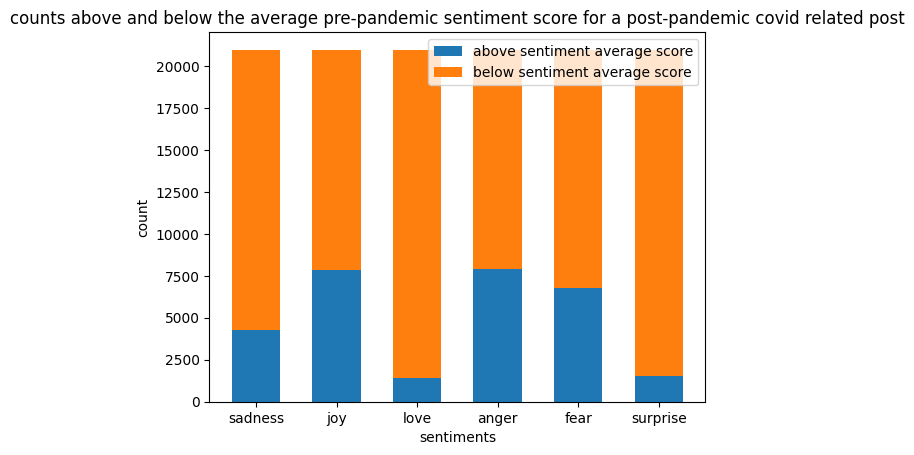

In [18]:
plt.bar(above_avg.keys(), above_avg.values(), label='above sentiment average score', width=.6)
plt.bar(below_avg.keys(), below_avg.values(), bottom=list(above_avg.values()), label='below sentiment average score', width=.6)

plt.xlabel('sentiments')
plt.ylabel('count')
plt.title('counts above and below the average pre-pandemic sentiment score for a post-pandemic covid related post')
plt.legend()

### Sentiment correlations
We also wanted to see the correlations between different sentiments, particularly sentiments that are negative vs positive. We can see in the "sadness vs joy" plot, submissions that have high joy scores are mostly low in sadness. And those that are high in sadness are low in joy. This is expected.

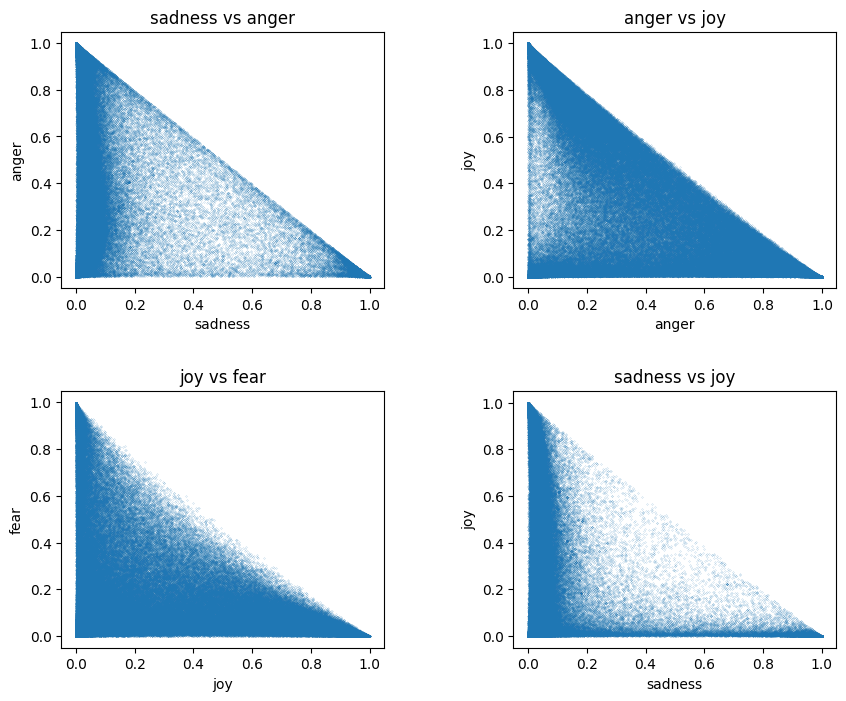

In [17]:

sadness = submissions_sentiments_pre['sadness']
anger = submissions_sentiments_pre['anger']
fear = submissions_sentiments_pre['fear']

plt.figure(figsize=(10, 8))

def plot_emotion_corr(e1, e2, plot_num):
  plt.subplot(plot_num)
  plt.xlabel(e1)
  plt.ylabel(e2)
  plt.scatter(submissions_sentiments_pre[e1], submissions_sentiments_pre[e2], s=.01)
  plt.title(f'{e1} vs {e2}')

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plot_emotion_corr('sadness', 'anger', 221)
plot_emotion_corr('anger', 'joy', 222)
plot_emotion_corr('joy', 'fear', 223)
plot_emotion_corr('sadness', 'joy', 224)

## Prominence of Sentiments

### Prominence of Sentiments Pre-covid
For all pre-covid posts, we'd like to see what percentage of the posts have each sentiment as its primary sentiment. For instance, we see that only 6.3% of the posts have sadness as the primary sentiment.

[0.06301453069016259, 0.4255912244610195, 0.007538315249812898, 0.36940637123219816, 0.13021942462950176, 0.0042301337373050795]


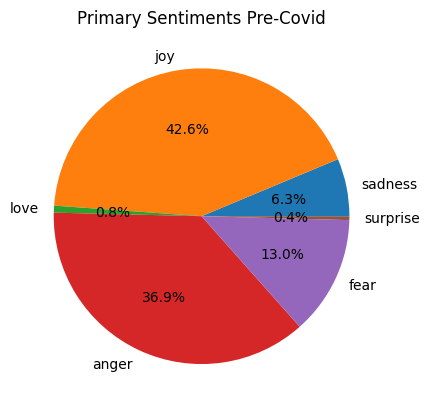

In [15]:
sentiment_count = submissions_sentiments_pre[['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']].idxmax(axis=1).value_counts()

sent_percent = []
for e in emotions:
    sent_percent.append(sentiment_count[e]/submissions_sentiments_pre.shape[0])
print(sent_percent)

plt.title("Primary Sentiments Pre-Covid")
plt.pie(sent_percent, labels=emotions, autopct='%1.1f%%')
plt.show()

### Prominence of Sentiments in Submissions During Covid
Similarly, for post-covid submissions (not necessarily submissions related to covid), we'd like to see what percentage of the posts have each sentiment as its primary sentiment.

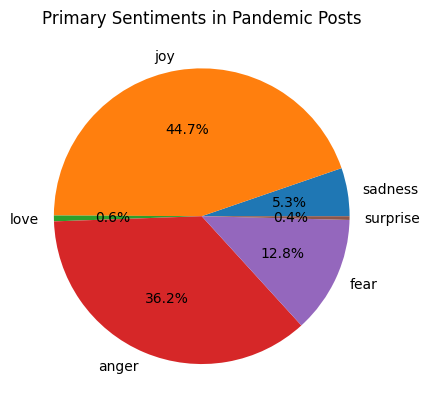

In [16]:
sentiment_count_post = submissions_post_df_subset[['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']].idxmax(axis=1).value_counts()

sent_percent_post = []
for e in emotions:
    sent_percent_post.append(sentiment_count_post[e]/submissions_post_df_subset.shape[0])

plt.title("Primary Sentiments in Pandemic Posts")
plt.pie(sent_percent_post, labels=emotions, autopct='%1.1f%%')
plt.show() 


### Prominence of Sentiments in Covid-Related Posts
Similarly, now we want to see for all post-covid posts that are related to COVID, what percentage of the posts have each sentiment as its primary sentiment?

In [17]:
# making every non-numeric value in sentiments as NaN
for e in emotions:
    submissions_covid_sentiments[e] = pd.to_numeric(submissions_covid_sentiments[e], errors='coerce')

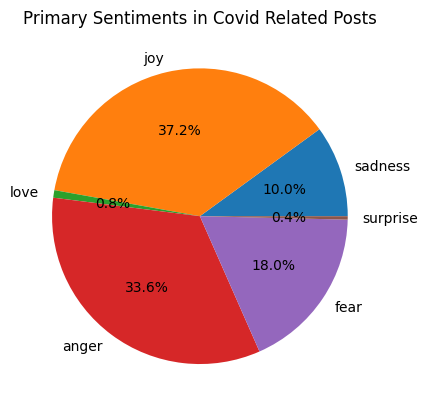

In [18]:
sentiment_count_covid = submissions_covid_sentiments[['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']].idxmax(axis=1).value_counts()

sent_percent_covid = []
for e in emotions:
    sent_percent_covid.append(sentiment_count_covid[e]/submissions_covid_sentiments.shape[0])

plt.title("Primary Sentiments in Covid Related Posts")
plt.pie(sent_percent_covid, labels=emotions, autopct='%1.1f%%')
plt.show() 

There is an increase in posts which have sadness and fear as its most prominent sentiment in the Covid-related posts after the pandemic started compared to the pre-covid posts, whereas there is some decrease in joy. Covid resulted in lots of negative emotions in people, so the uptick of posts with sad or fearful sentiments makes sense.

Text(0.5, 1.0, 'Primary Sentiment Comparison between Pre-covid vs Covid-related posts')

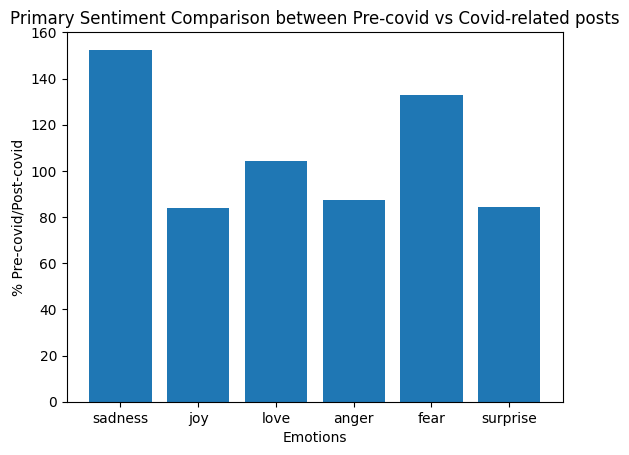

In [24]:
# Percent Increase/Decrease from Pre-covid vs. Post-Covid Covid-related posts. 
# Sadness and Fear increased by ~60% and ~40% respectively.

plt.bar(emotions, [sent_percent_covid[i]/sent_percent[i]*100 for i in range(len(sent_percent_covid))])
plt.xlabel("Emotions")
plt.ylabel("% Pre-covid/Post-covid")
plt.title("Primary Sentiment Comparison between Pre-covid vs Covid-related posts")

## Average Sentiments in Pre-Pandemic, During Pandemic, and Covid-Related Posts

We previously looked at the average sentiments of pre-pandemic posts. Now, we compare the average sentiments of post-pandemic submissions compared to the subset of post-pandemic submissions which are Covid-related.

In [29]:
pandemic_emotion_to_avg_score = {}
for e in emotions:
  pandemic_emotion_to_avg_score[e] = submissions_post_df_subset[e].mean()
  print(f"average {e} score: {pandemic_emotion_to_avg_score[e]}")

average sadness score: 0.07485065599525871
average joy score: 0.41073715711020375
average love score: 0.011097709377362028
average anger score: 0.33824889458635704
average fear score: 0.15626756774790895
average surprise score: 0.008798015140232263


In [26]:
covid_emotion_to_avg_score = {}
for e in emotions:
  covid_emotion_to_avg_score[e] = submissions_covid_sentiments[e].mean()
  print(f"average {e} score: {covid_emotion_to_avg_score[e]}")

average sadness score: 0.11855388495569016
average joy score: 0.347749896211666
average love score: 0.012550354248581103
average anger score: 0.32259870962503584
average fear score: 0.190884943742613
average surprise score: 0.007667649229759405


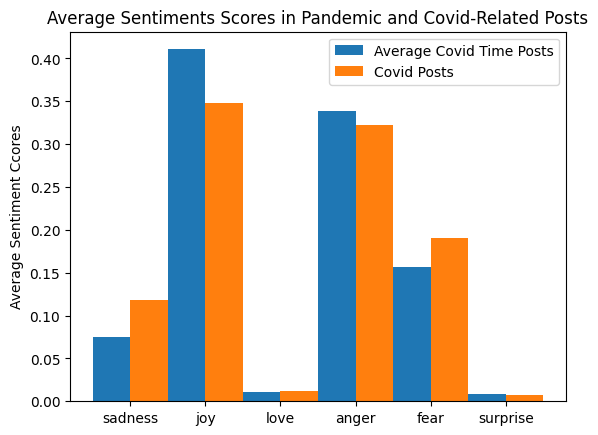

In [30]:
fig, ax = plt.subplots()
width1 = 0.5
plt.bar(np.arange(6), pandemic_emotion_to_avg_score.values(), width=width1)
plt.bar(np.arange(6)+width1, covid_emotion_to_avg_score.values(), width=width1)

ax.set_title('Average Sentiments Scores in Pandemic and Covid-Related Posts')
ax.set_ylabel('Average Sentiment Ccores')
ax.set_xticks(np.arange(6)+width1 / 2)
ax.set_xticklabels(emotions)
ax.legend(('Average Covid Time Posts', 'Covid Posts'))

Covid-related posts have higher average sadness and fear and lowe average joy than an average post released during Covid/the pandemic.

## Modelling Sentiment Scores over Time

Our goal is to model the pre-pandemic submissions scores and see if post-pandemic submission scores followed our models prediction. We wanted to model by simply fitting a best fit polynomial to pre-pandemic data for each sentiment by finding coefficients using `np.polyfit(x, y, degree)`, then forming the polynomial using `np.poly1d(coefficients)`, and graphing it using `plt.plot(x, polynomial(x)`. 

Considering the size of the pre-pandemic sentiment data, and that we had to experiment with multiple polynomial degress, and do this for each sentiment, this was too expensive for us. 

By plotting sentiment scores as seen below, we see a generally flat trend for pre-pandemic data for most of the sentiments. The interesting finding is that `fear`, `anger`, `sadness` scores spike right after the pandemic starts. This most likely is directly related to distressing news, uncertainty surrounding health, economic stability, and changes to daily life caused by the pandemic. 

We also found that interestingly the `joy` sentiment also spikes after the pandemic. The unexpected spike in joy might have been a coping mechanism or a response to shared moments of resilience. It's possible that during difficult times, people sought out positive connections and shared hopeful news, and supported each other.

Other emotions like surprise or love didn't have too big of a different compared to pre-pandemic times.

In [2]:
submissions_sentiments_pre = pd.read_csv("submissions_pre_with_sentiments.csv")
submissions_covid_sentiments = pd.read_csv("covid_submissions_post_with_sentiments.csv")

Since the number of pre-pandemic submissions are much more than covid related post-pandemic submissions, we decided to randomly sample a subset of the pre-pandemic submissions. The size of this sample would be the same as the size of the covid-related post-pandemic posts. This is for plotting purposes only.

In [4]:
submissions_sentiments_pre_sampled = submissions_sentiments_pre.sample(n=len(submissions_covid_sentiments), random_state=42)

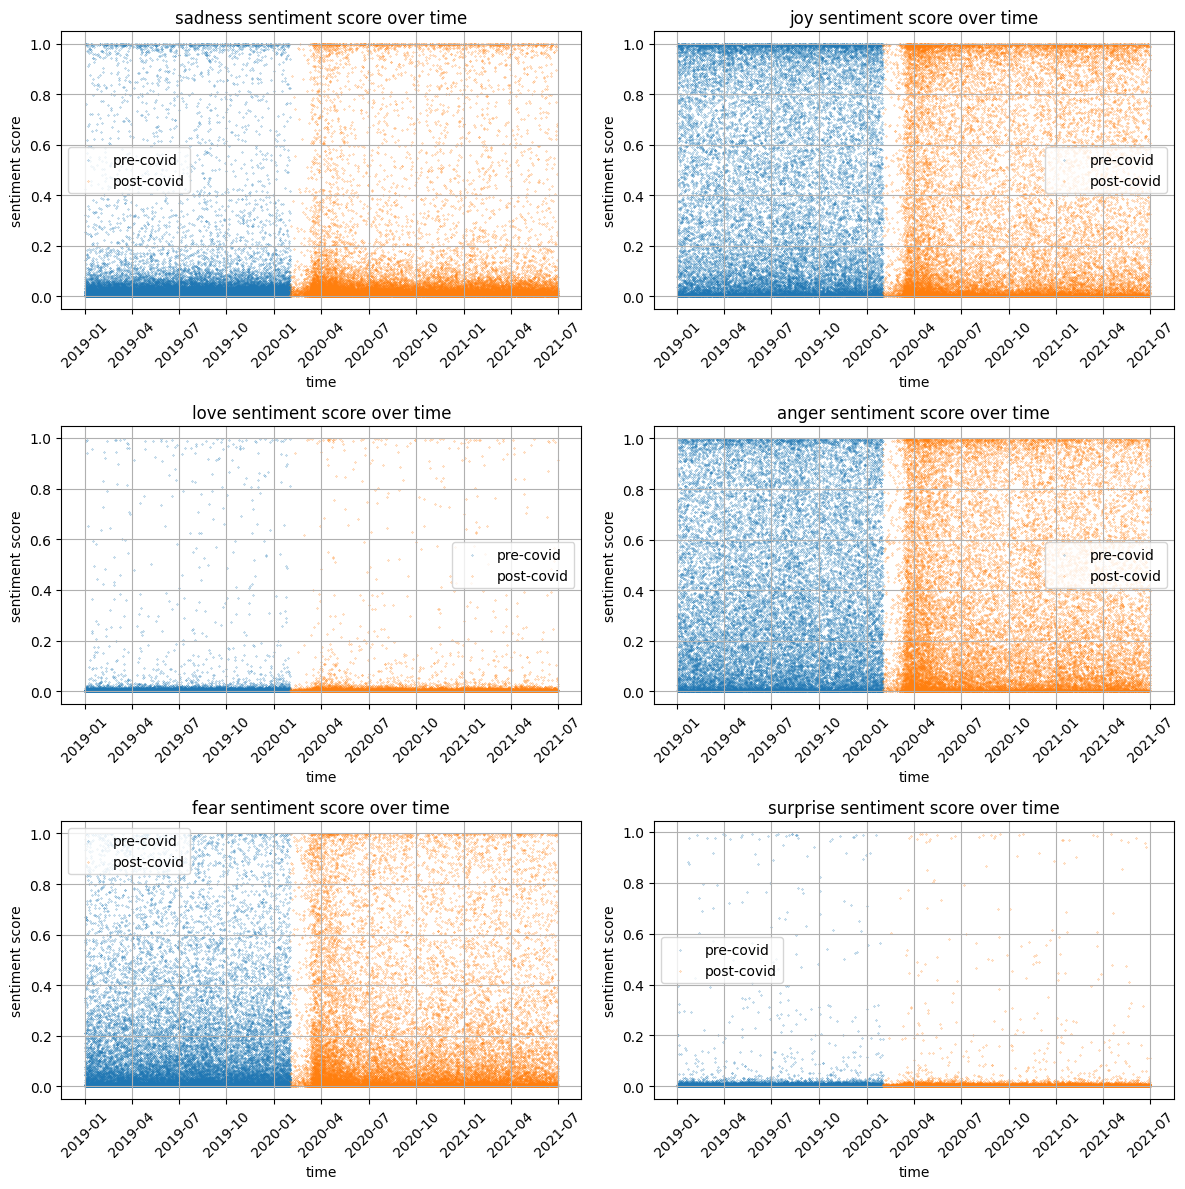

In [7]:
# convert UNIX timestamps to datetime (this wasn't needed in pre-processing but needed here)
submissions_sentiments_pre_sampled['created_utc'] = pd.to_datetime(submissions_sentiments_pre_sampled['created_utc'], unit='s')

fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs = axs.flatten() # it was suggested online to flatten the subplot array to easily iterate over axes

for i, emotion in enumerate(emotions):
  # finding row and column of subplot
  row, col = i // 2, i % 2
  
  # plot sentiment scoreover time
  axs[i].scatter(submissions_sentiments_pre_sampled['created_utc'], 
                    submissions_sentiments_pre_sampled[emotion], label='pre-covid', s=0.05)
  axs[i].scatter(submissions_covid_sentiments['created_utc'], 
                    submissions_covid_sentiments[emotion], label='post-covid', s=0.05)
  
  axs[i].set_xlabel('time')
  axs[i].set_ylabel('sentiment score')
  axs[i].set_title(f'{emotion} sentiment score over time')
  axs[i].legend()
  axs[i].grid(True)
  axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()